## Task 2. A/B test

### 1. Importing libraries

In [35]:
import pandas as pd
import numpy as np
import pandahouse as ph
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statistics
import numpy as np

### 2. Retrieving data from database

In [36]:
connection = {'host': 'https://clickhouse.lab.karpov.courses/',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [37]:
 q = '''
select distinct user_id, exp_group, sum(action='like') as likes, sum(action='view') as views, likes/views as ctr
from {db}.feed_actions 
where (toDate(time) between '2023-01-31' and '2023-02-06') and exp_group in (1,2)
group by exp_group, user_id
'''

In [38]:
 df = ph.read_clickhouse(q, connection=connection)
df

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750
...,...,...,...,...,...
20026,132567,1,45,296,0.152027
20027,30872,1,11,59,0.186441
20028,25383,2,42,127,0.330709
20029,139020,2,24,114,0.210526


### 3. Distribution CTR by group

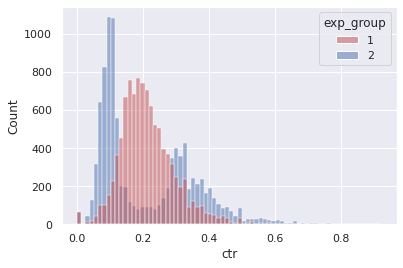

In [39]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### 4. T-test

In [40]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

# According to the results of the t-test, the CTR values in the two groups do not differ significantly.

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

### 5. Mann–Whitney U test


In [41]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

# According to the results of the Mann-Whitney test, the CTR values in the two groups are significantly different..

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

### 6. Smoothed CTR

In [42]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()



<AxesSubplot:xlabel='ctr', ylabel='Count'>

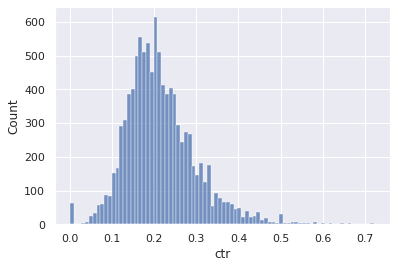

In [43]:
group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr, 
             kde = False)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

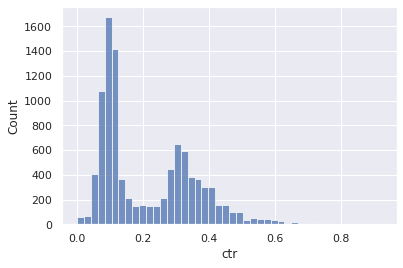

In [44]:
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr, 
             kde = False)

In [45]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)


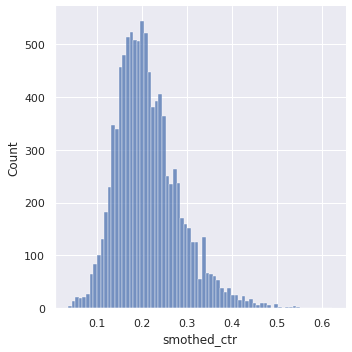

In [46]:
sns.displot(group1.smothed_ctr, 
             kde = False)

In [47]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)


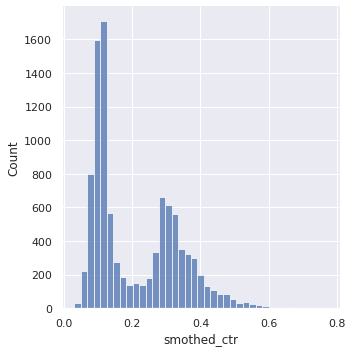

In [48]:
sns.displot(group2.smothed_ctr, 
             kde = False)

In [49]:
stats.ttest_ind(group1['smothed_ctr'], group2['smothed_ctr'], equal_var=False) 

# The t-test on smoothed CTR (Click-Through Rate) indicates that there is a difference between the experimental groups.

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

### 7. Poisson Bootstrap

In [50]:
likes1 = df.loc[df['exp_group'] == 1, 'likes'].to_numpy()
views1 = df.loc[df['exp_group'] == 1, 'views'].to_numpy()
likes2 = df.loc[df['exp_group'] == 2, 'likes'].to_numpy()
views2 = df.loc[df['exp_group'] == 2, 'views'].to_numpy()

In [51]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

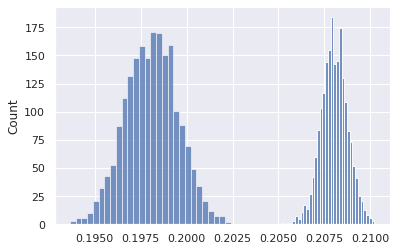

In [52]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

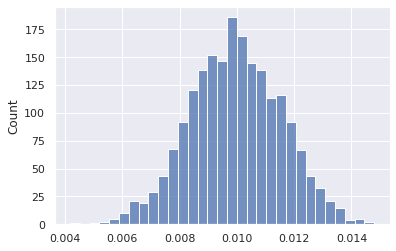

In [53]:
sns.histplot(ctr1 - ctr2)
#The Poisson bootstrap analysis reveals that the global CTR data does not overlap, indicating that the CTR of the first group is higher than the CTR of the second group.

### 8. Bucket Testing

In [54]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-01-31' and '2023-02-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

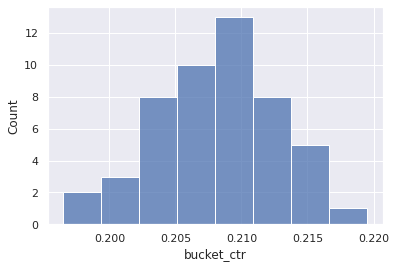

In [55]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].bucket_ctr)


<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

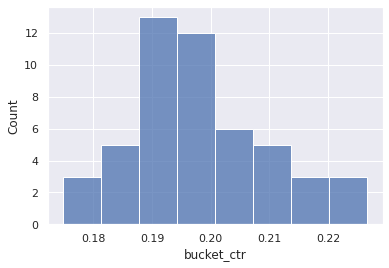

In [56]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_ctr)


In [57]:
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

# The zone of overlapping values between the buckets of the two groups is relatively small.

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [58]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

# Once again, we observe that the CTR values in the two groups are different.

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

### 9. Results

The output results are as follows:
* Primary t-test: p-value=0.4780623130874935 (no significant difference in the data between the experimental groups)
* Primary Mann-Whitney test: p-value=6.0376484617779035e-56 (the zone of overlapping values between the experimental groups is relatively small)                                                     
* t-test on smoothed CTR: p-value=0.0223769815558559 (significant difference in the data between the experimental groups)
* Poisson bootstrap analysis: The method indicates that the global CTR data does not overlap, and the CTR of the first group is higher than the CTR of the second group.
* t-test on bucket transformation: p-value=3.4455951649945907e-07 (significant difference in the bucket values)
* Mann-Whitney test on bucket transformation: p-value=2.859963936492646e-07 (the zone of overlapping values is relatively small)

Based on the data, the following conclusions can be drawn:
1) The distribution of values in the second experimental group is not normal (bimodal, asymmetric), so applying parametric A/B testing methods without additional data transformation would not be appropriate. Therefore, we cannot rely on the results of the primary t-test.

2) The Mann-Whitney test consistently showed that the zone of overlapping values between the samples is relatively small, indicating that there are differences between the experimental groups.

3) Smoothing the CTR allowed us to obtain a t-test value where we are inclined to reject the null hypothesis. However, visually, the distribution of the second group still appears non-normal.

4) After the bucket transformation of the data, the distribution of values in the second experimental group became more or less normal, and the t-test yielded a more confident p-value. This suggests that the new feature likely had an impact on the CTR.

5) The Poisson bootstrap analysis indicated that the new feature ultimately had a negative effect on the CTR.

6) Based on the overall experiment, it can be concluded that the new algorithm had a negative impact on user engagement, and it is not advisable to apply it to all users.